# Demonstrate regridding workflow

In [18]:
%matplotlib inline
import os
import warnings
from datetime import date, datetime, timezone

import xarray as xr
import numpy as np
from netCDF4 import default_fillvals

import matplotlib.pyplot as plt

import esmlab
import esmlab_regrid

import pop_tools 

import config
import util

In [19]:
id_string = 'regrid_demo.ipynb from github.com/marbl-ecosys/marbl-forcing/Fe_sediment_flux'

## construct regridder

In [20]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/mclong/esmlab-regrid'

In [21]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx1v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)
regrid_operator

/glade/work/mclong/esmlab-regrid
/glade/work/mclong/esmlab-regrid


### get POP destination grid

In [22]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w      (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot  (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    DXT      (nlat, nlon) float64 2.339e+06 2.339e+06 ... 1.472e+06 1.473e+06
    DYT      (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    TAREA    (nlat, nlon) float64 7.961e+14 7.961e+14 ... 4.257e+14 4.258e+14
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0

## read WOA data

Monthly WOA data has 37 vertical levels:
```
 depth = 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
    85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
    400, 425, 450, 475, 500 ;
```

Annnual data has 102 vertical levels:
```
 depth = 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
    85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375,
    400, 425, 450, 475, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
    1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
    1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300,
    2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
    3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700,
    4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500 ;
```

We blend the annual and monthly data.

In [23]:
woa_pth = '/glade/work/mclong/woa2013v2/1x1d'
pop_to_woa_vars = {'TEMP': 't_an', 'SALT': 's_an', 'NO3': 'n_an', 'O2': 'o_an', 'dO2sat': 'O_an',
                  'AOU': 'A_an', 'SiO3': 'i_an', 'PO4': 'p_an'}

woa_to_pop_vars = {woa: pop for pop, woa in pop_to_woa_vars.items()}

def woa_filename(pop_varname, month):
    woa_var_code = pop_to_woa_vars[pop_varname][0]
    
    if pop_varname in ['TEMP', 'SALT']:
        return f'{woa_pth}/woa13_decav_{woa_var_code}{month:02d}_01v2.nc' 
    else:
        return f'{woa_pth}/woa13_all_{woa_var_code}{month:02d}_01.nc'
    

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916    
    
def open_woa_annjan_blend(pop_varname):
    
    # read ann and jan data
    woa_var = pop_to_woa_vars[pop_varname]    
    dsann = xr.open_dataset(woa_filename(pop_varname, month=0), decode_times=False)
    dsjan = xr.open_dataset(woa_filename(pop_varname, month=1), decode_times=False)
    attrs = dsann[woa_var].attrs

    # drop time and other vars
    dsann = dsann.isel(time=0, drop=True)
    dsjan = dsjan.isel(time=0, drop=True)        
    dsann = dsann.drop([v for v in dsann.data_vars if v != woa_var])
    dsjan = dsjan.drop([v for v in dsjan.data_vars if v != woa_var])
    
    # align datasets to fill missing depths in jan data
    dsann, dsjan = xr.align(dsann, dsjan, join='outer')
    
    # replace ann data with jan data where it exists
    dsann[woa_var] = xr.where(dsjan[woa_var].notnull(), dsjan[woa_var], dsann[woa_var])
   
    # modify attributes
    attrs['long_name'] = (attrs['standard_name']
                          .replace('moles_concentration_of_', '')
                          .replace('_in_sea_water', ''))

    if attrs['units'] == 'micromoles_per_liter':
        attrs['units'] = 'mmol/m^3'

    # convert units for oxygen
    if pop_varname == 'O2' and attrs['units'] == 'milliliters_per_liter':
        dsann[woa_var] = dsann[woa_var] * mlperl_2_mmolm3
        attrs['units'] = 'mmol/m^3'
        attrs['long_name'] = 'Oxygen'
    
    # remove unneeded attrs
    del attrs['standard_name'] 
    del attrs['cell_methods']
    del attrs['grid_mapping']    
        
    dsann[woa_var].attrs = attrs
   
    # return dataset with POP names
    return dsann.rename({k: v for k, v in woa_to_pop_vars.items() if k in dsann.data_vars})
    

In [24]:
varlist = ['TEMP', 'SALT', 'NO3', 'O2', 'SiO3', 'PO4']

ds_list = []
for v in varlist:
    dsi = open_woa_annjan_blend(v)
    ds_list.append(dsi)
ds_woa = xr.merge(ds_list)
ds_woa

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    TEMP     (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SALT     (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    NO3      (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    O2       (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SiO3     (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    PO4      (depth, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/esmlab_regrid/core.py:203: RuntimeWarning: invalid value encountered in greater
  data_dst = np.where(ones_dst > 0.0, data_dst, np.nan)


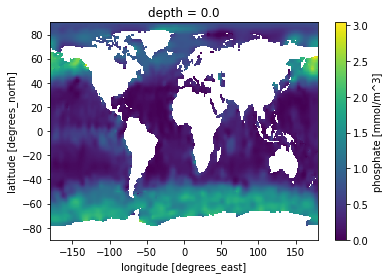

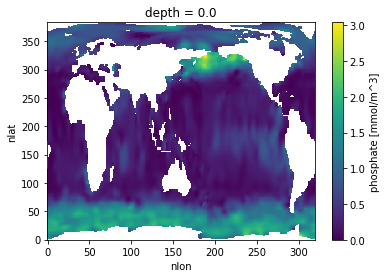

In [25]:
dso_lateral = xr.Dataset()
for v in varlist:
    dso_lateral[v] = regrid_operator(ds_woa[v], renormalize=True)
    dso_lateral[v].attrs = ds_woa[v].attrs

dso_lateral = dso_lateral.rename({'lon': 'nlon', 'lat': 'nlat'})

dso_lateral.depth.data = dso_lateral.depth.data * 1e2
dso_lateral.depth.attrs['units'] = 'cm'

plt.figure()
ds_woa[varlist[-1]].isel(depth=0).plot()

plt.figure()
dso_lateral[varlist[-1]].isel(depth=0).plot()

## remap in vertical vertical coordinate

Take a peak at the two vertical coordinates.

In [26]:
ds_dst.z_t.values

array([5.00000000e+02, 1.50000000e+03, 2.50000000e+03, 3.50000000e+03,
       4.50000000e+03, 5.50000000e+03, 6.50000000e+03, 7.50000000e+03,
       8.50000000e+03, 9.50000000e+03, 1.05000000e+04, 1.15000000e+04,
       1.25000000e+04, 1.35000000e+04, 1.45000000e+04, 1.55000000e+04,
       1.65098404e+04, 1.75479050e+04, 1.86291267e+04, 1.97660278e+04,
       2.09711380e+04, 2.22578285e+04, 2.36408829e+04, 2.51370163e+04,
       2.67654191e+04, 2.85483651e+04, 3.05119224e+04, 3.26867997e+04,
       3.51093492e+04, 3.78227603e+04, 4.08784664e+04, 4.43377712e+04,
       4.82736729e+04, 5.27728001e+04, 5.79372891e+04, 6.38862622e+04,
       7.07563306e+04, 7.87002493e+04, 8.78825247e+04, 9.84705867e+04,
       1.10620419e+05, 1.24456691e+05, 1.40049717e+05, 1.57394639e+05,
       1.76400324e+05, 1.96894419e+05, 2.18645653e+05, 2.41397155e+05,
       2.64900126e+05, 2.88938459e+05, 3.13340457e+05, 3.37979354e+05,
       3.62767025e+05, 3.87645176e+05, 4.12576809e+05, 4.37539251e+05,
      

In [27]:
dso_lateral.depth.values

array([0.00e+00, 5.00e+02, 1.00e+03, 1.50e+03, 2.00e+03, 2.50e+03,
       3.00e+03, 3.50e+03, 4.00e+03, 4.50e+03, 5.00e+03, 5.50e+03,
       6.00e+03, 6.50e+03, 7.00e+03, 7.50e+03, 8.00e+03, 8.50e+03,
       9.00e+03, 9.50e+03, 1.00e+04, 1.25e+04, 1.50e+04, 1.75e+04,
       2.00e+04, 2.25e+04, 2.50e+04, 2.75e+04, 3.00e+04, 3.25e+04,
       3.50e+04, 3.75e+04, 4.00e+04, 4.25e+04, 4.50e+04, 4.75e+04,
       5.00e+04, 5.50e+04, 6.00e+04, 6.50e+04, 7.00e+04, 7.50e+04,
       8.00e+04, 8.50e+04, 9.00e+04, 9.50e+04, 1.00e+05, 1.05e+05,
       1.10e+05, 1.15e+05, 1.20e+05, 1.25e+05, 1.30e+05, 1.35e+05,
       1.40e+05, 1.45e+05, 1.50e+05, 1.55e+05, 1.60e+05, 1.65e+05,
       1.70e+05, 1.75e+05, 1.80e+05, 1.85e+05, 1.90e+05, 1.95e+05,
       2.00e+05, 2.10e+05, 2.20e+05, 2.30e+05, 2.40e+05, 2.50e+05,
       2.60e+05, 2.70e+05, 2.80e+05, 2.90e+05, 3.00e+05, 3.10e+05,
       3.20e+05, 3.30e+05, 3.40e+05, 3.50e+05, 3.60e+05, 3.70e+05,
       3.80e+05, 3.90e+05, 4.00e+05, 4.10e+05, 4.20e+05, 4.30e

In [28]:
dso_lat_vert = xr.Dataset()

dim = 'depth'
new_coord = ds_dst.z_t
for v in varlist:
    da = dso_lateral[v]
    dso_lat_vert[v] = da.interp(coords={dim: new_coord},
                                method='linear',
                                assume_sorted=True,
                                kwargs={'bounds_error': False})
    dso_lat_vert[v] = xr.where(np.isclose(dso_lat_vert[v], 0., atol=1e-10), 0., 
                               dso_lat_vert[v])
    dso_lat_vert[v].attrs = dso_lateral[v].attrs
    
dso_lat_vert = dso_lat_vert.drop([dim])
dso_lat_vert

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

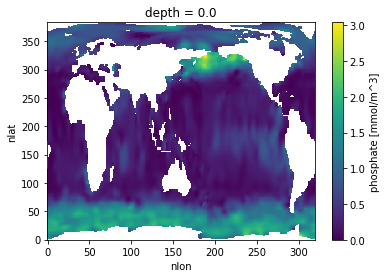

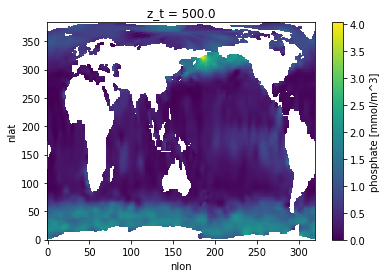

In [29]:
plt.figure()
dso_lateral[varlist[-1]].isel(depth=0).plot()

plt.figure()
dso_lat_vert[varlist[-1]].isel(z_t=0).plot()

## perform lateral smoothing operation

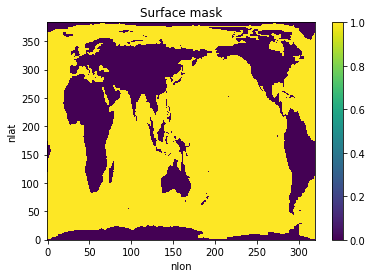

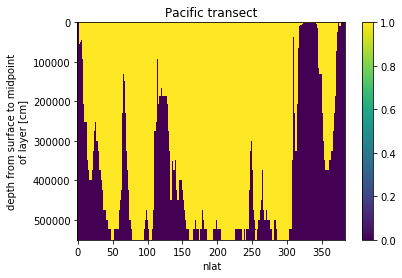

In [30]:
nk = len(ds_dst.z_t)
nj, ni = ds_dst.KMT.shape

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < ds_dst.KMT)
MASK = xr.where(MASK.notnull(), 1., 0.)

MASK['z_t'] = ds_dst.z_t

plt.figure()
MASK.isel(z_t=0).plot()
h = plt.title('Surface mask')

plt.figure()
MASK.isel(nlon=200).plot(yincrease=False)
h = plt.title('Pacific transect')

In [31]:
# loop over variables
dso_smooth = xr.Dataset()
for v in varlist:    
    
    # apply lateral smooth
    dso_smooth[v] = util.fill_ocean_POP(dso_lat_vert[v].copy(), mask=(MASK == 1.), ltripole=ltripole)
    dso_smooth[v].attrs = dso_lat_vert[v].attrs
    
    # perform vertical fill if necessary
    unfilled = dso_smooth[v].isnull() & (MASK == 1.)                    
    if not unfilled.any():
        continue   
    for k in range(1, ds_dst.z_t.shape[0]):
        dso_smooth[v][k, :, :] = xr.where(unfilled[k, :, :], 
                                          dso_smooth[v][k-1, :, :], 
                                          dso_smooth[v][k, :, :])
        
    if (dso_smooth[v].isnull() & (MASK == 1.)).any():
        warnings.warn(f'{v} still has missing values')
    
dso_smooth    

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan

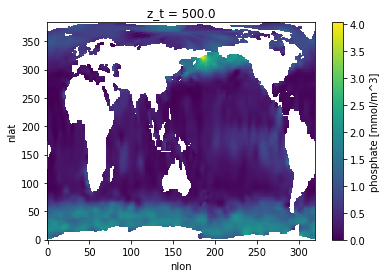

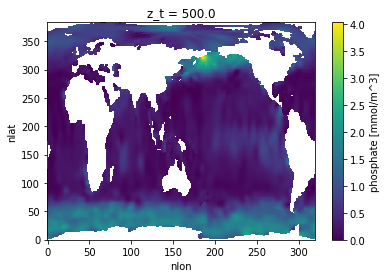

In [32]:
plt.figure()
dso_lat_vert[varlist[-1]].isel(z_t=0).plot()

plt.figure()
dso_smooth[varlist[-1]].isel(z_t=0).plot()

In [33]:
dso = dso_smooth.copy()

for v in dso.variables:
    dso[v].encoding['_FillValue'] = default_fillvals['f4']
    dso[v].encoding['dtype'] = np.float32
    if dso.NO3.dims == {'z_t', 'nlat', 'nlon'}:
        dso[v].attrs['coordinates'] = 'TLONG TLAT z_t'
    
for v in ds_dst.variables:
    dso[v] = ds_dst[v]
    
for v in dso.variables:
    if '_FillValue' not in dso[v].encoding:
        dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by {id_string} on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t      (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w      (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot  (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SALT     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    NO3      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    O2       (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    SiO3     (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    PO4      (z_t, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 

In [34]:
file_out = f'{config.dirout}/marbl_jan_ic_woa_{dst_grid}.c{datestamp}.nc'
dso.to_netcdf(file_out)